<a href="https://colab.research.google.com/github/hajonghyun/installPytorch_study/blob/main/5_torch_multiclass.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

### 구글 드라이브와 연동 (코랩 새로 켤때마다 지워지기 때문에)

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### 구글 GPU 사용

In [3]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(DEVICE)

cuda


### train_DS 와 test_DS 구경

In [4]:
transform = transforms.ToTensor()
train_DS = datasets.MNIST(root = '/content/drive/MyDrive/ROKAF/인스톨 파이토치/data', train=True, download=True, transform=transform)
test_DS = datasets.MNIST(root = '/content/drive/MyDrive/ROKAF/인스톨 파이토치/data', train=False, download=True, transform=transform)

# PyTorch: `transforms.ToTensor()`의 핵심 역할

`transforms.ToTensor()`는 이미지 데이터(Raw Data)를 파이토치 모델이 학습할 수 있는 **'표준 규격'**으로 변환하는 **필수 전처리 도구**입니다.

## 1. 3가지 핵심 기능
이 함수는 한 번에 다음 세 가지 작업을 수행합니다.

1.  **자료형 변환 (Type Conversion)**
    * `PIL Image` 또는 `numpy.ndarray` (정수형 `uint8`) $\rightarrow$ **`FloatTensor` (실수형 `float32`)**
    * **이유:** 신경망의 가중치 업데이트(미분)를 위해서는 정밀한 실수 연산이 필수입니다.

2.  **스케일링 (Scaling)**
    * **0 ~ 255** 범위의 픽셀 값 $\rightarrow$ **0.0 ~ 1.0** 범위로 정규화
    * **이유:** 큰 숫자는 기울기 폭주(Gradient Exploding)를 유발합니다. 0~1 사이의 작은 값에서 학습이 가장 안정적입니다.

3.  **차원 변경 (Dimension Swap) ★ 중요**
    * **(H, W, C)** $\rightarrow$ **(C, H, W)**
    * `높이, 너비, 채널` 순서의 데이터를 파이토치 표준인 `채널, 높이, 너비` 순서로 바꿉니다.
    * **이유:** 파이토치 내부 연산(Conv2d 등)은 채널(C)이 가장 앞에 오는 것을 전제로 구현되어 있습니다.

---

## 2. Code: Before & After 비교
가상의 픽셀 데이터(빨간점 하나)를 통해 변환 과정을 확인합니다.

```python
import numpy as np
import torch
from torchvision import transforms

# [Before] 원본 데이터 (Numpy)
# 구조: (높이 H=1, 너비 W=1, 채널 C=3), 값 범위: 0~255
raw_data = np.array([[[255, 0, 0]]], dtype='uint8')

print(f"원본 모양: {raw_data.shape}")
print(f"원본 값:\n{raw_data}")

# --- 변환 수행 ---
transform = transforms.ToTensor()
tensor_data = transform(raw_data)
# -----------------

# [After] 변환 데이터 (Tensor)
# 구조: (채널 C=3, 높이 H=1, 너비 W=1), 값 범위: 0.0~1.0
print(f"변환 모양: {tensor_data.shape}")
print(f"변환 값:\n{tensor_data}")
```

### 3. 실행 결과 (Output)

```text
원본 모양: (1, 1, 3)
원본 값:
[[[255   0   0]]]

------------------------------

변환 모양: torch.Size([3, 1, 1])  <-- 채널(3)이 맨 앞으로 이동 (C, H, W)
변환 값:
tensor([[[1.],      <-- 255가 1.0으로 스케일링 됨 (R)
         [0.],      <-- (G)
         [0.]]])    <-- (B)
```

## 요약
`transforms.ToTensor()`를 사용하지 않으면 모델은 데이터를 **입력받을 수 없습니다(Shape Mismatch)**. 모델이 소화하기 좋게 **"자르고(차원변경), 으깨서(스케일링), 부드럽게(실수변환)"** 만들어주는 과정입니다.

In [5]:
print(train_DS)
print(test_DS)
print(len(train_DS))
print(len(test_DS))

Dataset MNIST
    Number of datapoints: 60000
    Root location: /content/drive/MyDrive/ROKAF/인스톨 파이토치/data
    Split: Train
    StandardTransform
Transform: ToTensor()
Dataset MNIST
    Number of datapoints: 10000
    Root location: /content/drive/MyDrive/ROKAF/인스톨 파이토치/data
    Split: Test
    StandardTransform
Transform: ToTensor()
60000
10000


In [6]:
train_DS.classes # . 뒤에 탭 하면 이것저것 뜬다.

['0 - zero',
 '1 - one',
 '2 - two',
 '3 - three',
 '4 - four',
 '5 - five',
 '6 - six',
 '7 - seven',
 '8 - eight',
 '9 - nine']

In [7]:
train_DS.class_to_idx # 클래스에 대한 label을 볼 수 있음

{'0 - zero': 0,
 '1 - one': 1,
 '2 - two': 2,
 '3 - three': 3,
 '4 - four': 4,
 '5 - five': 5,
 '6 - six': 6,
 '7 - seven': 7,
 '8 - eight': 8,
 '9 - nine': 9}

In [8]:
train_DS.data.shape # 28X28 짜리 이미지가 60000개 들어있다.

torch.Size([60000, 28, 28])

In [9]:
train_DS[0]

(tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 

In [10]:
train_DS.data[0]

tensor([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   3,  18,
          18,  18, 126, 136, 175,  26, 166, 255, 247, 127,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   

# [PyTorch] 개념 확실히 잡기: `.data[0]` vs `[0]`의 차이

데이터셋에서 데이터를 꺼내는 두 가지 방식의 차이는 **"요리 전이냐, 요리 후냐"**의 차이입니다.

## 1. 핵심 비유 (Analogy)
| 코드 | 비유 | 상태 | 설명 |
| :--- | :--- | :--- | :--- |
| **`train_DS.data[0]`** | **냉장고 속 생고기** | **Raw Data** | 창고에 쌓여있는 **원본 그대로**의 상태. (먹을 수 없음/학습 불가) |
| **`train_DS[0]`** | **잘 구워진 스테이크** | **Processed** | 주문(인덱싱)이 들어오자마자 **손질(Transform)**해서 내온 상태. (먹을 수 있음/학습 가능) |

## 2. 기술적 차이점 비교

| 구분 | `dataset.data[index]` | `dataset[index]` |
| :--- | :--- | :--- |
| **호출 대상** | 내부 변수(속성) 직접 접근 | **`__getitem__` 메서드** 실행 |
| **Transform 적용** | **X** (적용 안 됨) | **O** (`ToTensor` 적용 됨) |
| **값의 범위** | **0 ~ 255** (정수) | **0.0 ~ 1.0** (실수) |
| **데이터 타입** | `torch.uint8` (1 Byte) | `torch.float32` (4 Bytes) |

## 3. "왜 미리 변환해서 저장하지 않는가?" (Why?)
**메모리 효율성(Memory Efficiency)** 때문입니다.

* **`uint8` (원본)**: 픽셀당 1바이트만 차지.
* **`float32` (변환 후)**: 픽셀당 4바이트 차지.

만약 모든 데이터를 미리 `float32`로 변환해서 메모리에 올려두면, **RAM 사용량이 4배로 폭증**하여 컴퓨터가 멈출 수 있습니다. 그래서 파이토치는 **"저장은 압축해서(Raw), 사용은 그때그때 변환해서(On-the-fly)"** 방식을 사용합니다.

## 4. 내부 동작 코드 (Mental Model)
우리가 `train_DS[0]`이라고 코드를 칠 때, 내부에서는 아래 함수가 실행됩니다.

```python
def __getitem__(self, index):
    # 1. 창고(self.data)에서 원본(0~255)을 꺼낸다
    img = self.data[index]
    
    # 2. 이 순간에 Transform이 개입한다! (여기가 핵심)
    #    (0~255 -> 0.0~1.0으로 변환 및 차원 변경)
    if self.transform is not None:
        img = self.transform(img)
        
    # 3. 변환된 결과(Tensor)를 반환한다
    return img, target
```

++

train_DS[0]은 이미지 하나만 덜렁 주는 게 아니라, (이미지, 정답 라벨) 이렇게 두 개가 묶인 **튜플(Tuple)**입니다

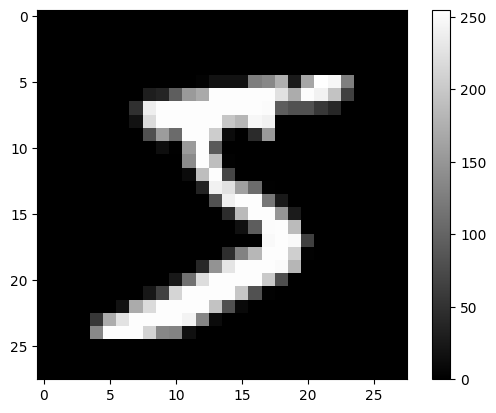

In [11]:
plt.imshow(train_DS.data[0],cmap='gray')
plt.colorbar()

In [12]:
print(train_DS.targets)
print(train_DS.targets.shape)

tensor([5, 0, 4,  ..., 5, 6, 8])
torch.Size([60000])


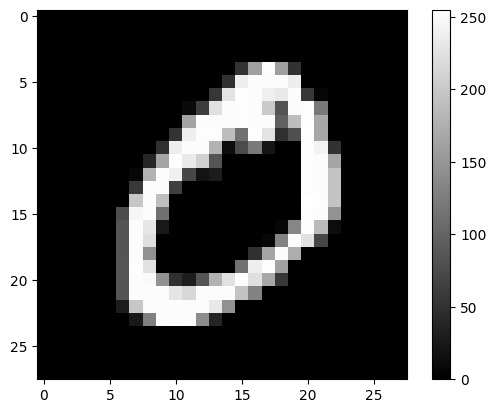

In [13]:
plt.imshow(train_DS.data[1],cmap='gray')
plt.colorbar()

### Data Loader 구경

# 📚 [Deep Dive] Optimizer vs DataLoader: 누가 학습 방식을 결정하는가?

"GD, SGD, Mini-batch GD... 이름은 Optimizer가 가지고 있는데, 왜 결정권은 DataLoader에게 있을까?"

## 1. 핵심 요약: 역할의 분리

AI 학습 코드를 짤 때, 이 두 가지 역할을 명확히 구분해야 헷갈리지 않습니다.

| 구분 | 코드 (변수명) | 역할 비유 | 실제 하는 일 |
| :--- | :--- | :--- | :--- |
| **Optimizer** | `optim.SGD` | **요리사 (Chef)** 👨‍🍳 | 재료가 오면 레시피(미분 공식)대로 **요리(업데이트)**만 함. |
| **DataLoader** | `DataLoader` | **재료 손질 담당 (Prep)** 🔪 | 창고(Dataset)에서 재료를 꺼내 **몇 개씩 묶어서(Batch)** 줄지 결정함. |

> **💡 결론:** 요리사(`optim.SGD`)는 재료가 1개 오든 100개 오든 상관하지 않습니다. **"한 번에 몇 개를 줄지"를 정하는 `DataLoader`의 `batch_size`가 학습 방식(SGD vs Mini-batch)을 결정합니다.**

---

## 2. Batch Size에 따른 학습 방식의 변화

`optimizer = optim.SGD(...)` 코드는 그대로 두고, `DataLoader`의 설정만 바꿨을 때 내부 동작이 어떻게 변하는지 확인해 봅시다.

### ① Stochastic Gradient Descent (SGD)
**"데이터 1개 보고 1번 수정"**
* **특징:** 가장 기초적인 의미의 SGD.
* **설정:** `batch_size=1`
* **단점:** 너무 오래 걸리고, 데이터 하나하나의 노이즈(튀는 값)에 휘둘려 학습이 불안정함.

```python
# 요리사에게 재료를 1개씩 줌
train_DL = DataLoader(dataset, batch_size=1, shuffle=True)
```

### ② Batch Gradient Descent (GD)
**"데이터 6만 개(전체) 다 보고 1번 수정"**
* **특징:** 이론적으로 가장 완벽한 방향으로 학습함.
* **설정:** `batch_size=len(dataset)`
* **단점:** 메모리(RAM)가 터짐. 한 발자국 떼는 데 시간이 너무 오래 걸림.

```python
# 요리사에게 재료 6만 개를 한 번에 던짐 (주방 마비됨)
train_DL = DataLoader(dataset, batch_size=60000, shuffle=True)
```

### ③ Mini-batch Gradient Descent (★국룰)
**"데이터 32개(적당량) 보고 평균 내서 1번 수정"**
* **특징:** 속도와 안정성의 황금 밸런스. 현업에서 말하는 SGD는 사실 이걸 의미함.
* **설정:** `batch_size=32` (또는 64, 128...)
* **장점:** GPU 병렬 연산 효율이 좋고, 적당한 노이즈가 있어 과적합도 방지됨.

```python
# 요리사에게 재료를 32개씩 쟁반에 담아서 줌 (가장 효율적)
train_DL = DataLoader(dataset, batch_size=32, shuffle=True)
```

---

## 3. 코드 흐름으로 완벽 이해하기

```python
# 1. 수리공 고용 (이름은 SGD지만, 그냥 '업데이트 도구'일 뿐)
optimizer = optim.SGD(model.parameters(), lr=0.01)

# 2. 작업 반장(DataLoader)에게 "32개씩 묶어오라"고 지시 (여기가 핵심!)
# -> 이 숫자가 바로 학습 방식을 결정함
BATCH_SIZE = 32
train_DL = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)

# 3. 실전 학습
for ep in range(EPOCH):
    # loader가 32개씩 포장된 'x_batch'를 던져줌
    for x_batch, y_batch in train_DL:
        
        # [Inference] 32개 문제 동시에 풀기
        y_hat = model(x_batch)
        
        # [Loss] 32개 채점 결과의 '평균' 오차 계산
        loss = criterion(y_hat, y_batch)
        
        # [Update] 평균 오차를 기준으로 가중치 수정
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
```

---

## 4. 요약 (Takeaway)

1. **이름에 속지 말자:** `optim.SGD`를 쓴다고 무조건 1개씩 학습하는 게 아니다.
2. **범인은 DataLoader:** 데이터를 몇 묶음으로 쪼개서 줄지(`batch_size`)가 실제 학습의 성격(Mini-batch 여부)을 결정한다.
3. **국룰 세팅:** * `optimizer`: Adam 또는 SGD
   * `DataLoader`: `batch_size=32` (메모리 상황에 따라 64, 128로 증량)
   * `shuffle=True`: 학습 데이터는 무조건 섞어서 줄 것!

In [14]:
BATCH_SIZE = 32
train_DL = torch.utils.data.DataLoader(train_DS, batch_size=BATCH_SIZE, shuffle=True)
test_DL = torch.utils.data.DataLoader(test_DS, batch_size=BATCH_SIZE, shuffle=True)

In [15]:
train_DL.dataset  # DataLoader는 dataset도 가지고 있다.
# DataLoader가 있으면 Dasaset도 같이 있는 셈.

Dataset MNIST
    Number of datapoints: 60000
    Root location: /content/drive/MyDrive/ROKAF/인스톨 파이토치/data
    Split: Train
    StandardTransform
Transform: ToTensor()

# 🛠️ `transforms.ToTensor()`의 3가지 핵심 역할 완벽 해부

PyTorch 데이터 전처리에서 가장 먼저 등장하는 `ToTensor()`는 단순히 형식을 바꾸는 것이 아니라, **모델 학습을 위한 최적의 상태**로 데이터를 변환하는 3가지 중요한 작업을 수행합니다.

---

## 1. Data Type 변환: `numpy/PIL` $\to$ `Tensor`
**"민간인(CPU)을 군인(GPU)으로 입대시키는 과정"**

* **입력:** `PIL Image` 또는 `numpy.ndarray` (CPU 기반)
* **출력:** `torch.FloatTensor` (GPU 탑승 가능)
* **왜 하는가?**
    1.  **GPU 가속:** 오직 Tensor 형태여야만 `.to('cuda')`를 통해 GPU에서 고속 연산이 가능합니다.
    2.  **Autograd (자동 미분):** Tensor가 되어야만 역전파(`backward`) 시 미분 계산 경로(`grad_fn`)를 추적할 수 있습니다.
    3.  **고속 연산:** 파이토치는 Tensor 형태의 행렬 연산에 극도로 최적화되어 있습니다.

## 2. Shape 변경: `(H, W, C)` $\to$ `(C, H, W)`
**"기계가 좋아하는 순서로 재료 손질 (차원 생성 및 이동)"**

이미지의 종류(흑백/컬러)에 따라 동작 방식이 조금 다릅니다. 핵심은 **"무조건 채널(Channel)을 맨 앞으로 보낸다"**는 것입니다.

### ① Case A: 흑백 이미지 (예: MNIST)
**"없던 채널(두께)을 만들어준다 (Unsqueeze)"**
* **상황:** 원본 이미지가 채널 정보 없이 `(세로, 가로)` 형태의 2차원 평면일 때.
* **동작:** 맨 앞에 차원을 하나 추가해서 3차원으로 만듭니다.
* **변환:** `(28, 28)` $\to$ **`(1, 28, 28)`**
    * `1`: 채널 수 (흑백이므로 1)
    * `28`: 세로 (Height)
    * `28`: 가로 (Width)
* **이유:** PyTorch의 합성곱 계층(`nn.Conv2d`)은 입력으로 무조건 `(N, C, H, W)` 형태를 요구하기 때문에, 1장일 때도 반드시 `(C, H, W)` 형태를 갖춰야 합니다.

### ② Case B: 컬러 이미지 (예: CIFAR-10, 일반 사진)
**"채널의 위치를 맨 앞으로 이사시킨다 (Permute)"**
* **상황:** 원본 이미지가 `(세로, 가로, 채널)` 순서로 되어 있을 때.
* **동작:** 맨 뒤에 있던 채널 축을 맨 앞으로 옮깁니다.
* **변환:** `(28, 28, 3)` $\to$ **`(3, 28, 28)`**
    * `3`: 채널 수 (R, G, B)
* **이유:** GPU가 메모리를 읽을 때 색깔별로 묶여 있어야(Planar) 연산 속도가 훨씬 빠르기 때문입니다.

## 3. Scaling (정규화): `0 ~ 255` $\to$ `0.0 ~ 1.0`
**"학습 속도와 안정성을 위한 다이어트"**

* **동작:** 입력된 픽셀값(Int)을 255로 나누어 `0.0`에서 `1.0` 사이의 실수(Float)로 변환합니다.
* **왜 하는가?**
    1.  **학습 속도 향상:** 입력값이 작아야 오차 곡선이 완만해져서 최적점(Loss=0)으로 빠르게 직진할 수 있습니다. (큰 값은 지그재그로 학습됨)
    2.  **기울기 소실(Vanishing Gradient) 방지:** 값이 너무 크면 활성화 함수(Sigmoid 등)의 기울기가 0이 되어 학습이 멈추는 현상을 막습니다.
    3.  **계산 정밀도:** 컴퓨터가 실수를 계산할 때 가장 오차가 적은 범위입니다.

---

### ⚡ 요약: Before & After

| 구분 | 전 (Raw Data) | 후 (ToTensor 적용) | 비고 |
| :--- | :--- | :--- | :--- |
| **자료형** | `numpy.uint8` (정수) | `torch.float32` (실수) | GPU 연산 최적화 |
| **값의 범위** | `0` ~ `255` | `0.0` ~ `1.0` | 학습 안정성 확보 |
| **흑백 차원** | `(H, W)` | **`(1, H, W)`** | **채널 차원 생성** |
| **컬러 차원** | `(H, W, C)` | **`(C, H, W)`** | **채널 축 이동** |

======DS=======
<class 'torch.Tensor'>
torch.Size([60000, 28, 28])
torch.uint8
tensor([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   3,  18,
          18,  18, 126, 136, 175,  26, 166, 255

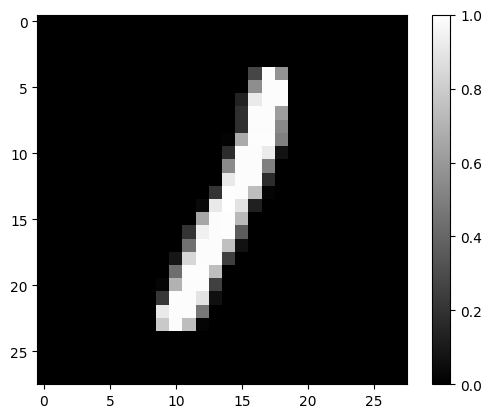

In [16]:
x_batch, y_batch = next(iter(train_DL)) # 데이터 한 국자 # next(iter(train_DS)) 는 한 장만 꺼내기

# ToTensor 의 역할
# 1. tensor로 바꾸고
# 2. "개 채 행 열" 로 바꾸고  (흑백이면 채=1, 컬러면 채=3)
#    여기선 "60000 X 1 X 28 X 28"
# 3. 0~255 값을 0~1 사이로 바꾼다. (int -> float)

print("======DS=======")
print(type(train_DS.data))
print(train_DS.data.shape)  # 개 행 열
print(train_DS.data.dtype)
print(train_DS.data[0])
print("======ToTensor 후======")
print(type(x_batch))
print(x_batch.shape)  # 개 채 행 열
print(x_batch.dtype)
print(x_batch[0])

plt.imshow(x_batch[0].squeeze(),cmap='gray')
plt.colorbar()
print(y_batch[0])

### 본격적으로 model 만들기!

In [17]:
from torch import nn

In [18]:
class MLP(nn.Module):
    def __init__(self):
        super().__init__()

        self.fcs=nn.Sequential(
            nn.Linear(1*28*28, 100),
            nn.ReLU(),
            nn.Linear(100,10),
            # 여기에 softmax 안 넣는게 맞다!!!
        )

    def forward(self, x):
        x = torch.flatten(x,start_dim=1)  # 1dim 부터 끝까지 합쳐라
        x = self.fcs(x)
        return x

# 🧠 nn.Linear의 입력 구조와 Flatten의 진정한 의미 (Feature 관점): ⭐⭐⭐⭐⭐

`nn.Linear`를 이해할 때는 "이미지를 편다"는 행위보다, **"Feature(특징) 차원을 어떻게 정의할 것인가"**가 핵심입니다.

---

## 1. `nn.Linear`의 입력 규칙: `... X 채(Feature)`
`nn.Linear`는 입력 텐서의 **맨 마지막 차원**을 **'특징(Feature) 채널'**로 인식합니다. 앞쪽 차원(Batch 등)이 몇 개가 있든 상관없이, 마지막 차원만 맞으면 작동합니다.

* **입력 가능 형태:**
    * `(채)` $\to$ 데이터 1개
    * `(개, 채)` $\to$ 데이터 N개 묶음 (Batch)
    * `(개, 개, 채)` $\to$ 데이터 N개 조의 묶음
    * `(개, ..., 채)`

> **핵심 정의:** 여기서 **'채(Channel)'**는 단순히 색상(Color)을 뜻하는 게 아니라, **"하나의 데이터를 설명하는 모든 특징(in_features)의 개수"**를 뜻합니다.

---

## 2. 이미지 데이터(MNIST)에서의 '채(Feature)' 정의

MNIST 원본 데이터는 `(60000, 1, 28, 28)` 형태입니다. 여기서 **60000(개)**을 제외한 나머지 부분이 **하나의 이미지 데이터**입니다.

그렇다면 이 이미지의 **진정한 Feature(채)**는 무엇일까요?
* `1` (색상 채널)인가? $\to$ **NO.** (색상 정보만으로는 그림을 설명 불가)
* `28` (가로/세로)인가? $\to$ **NO.**
* **`1 × 28 × 28` (전체 픽셀)인가? $\to$ YES.**

즉, 이 데이터는 **784개의 특징(Feature)**을 가진 데이터입니다.
따라서 `nn.Linear`에게 전달해야 할 **'채(Feature)'의 크기는 784**가 됩니다.

---

## 3. Flatten의 역할: `개 X 채` 형태로 맞추기

우리의 목표는 `(60000, 1, 28, 28)`을 `nn.Linear`가 좋아하는 **`(개, 채)`** 형태로 만드는 것입니다.

* **현재 상태:** `(개, color, 행, 열)`
    * 여기서 `color, 행, 열`이 흩어져 있음.
* **목표 상태:** `(개, Feature)`
    * 여기서 `Feature` = `color × 행 × 열`

따라서 **`start_dim=1`**을 사용하여, 1번 차원부터 끝까지를 **하나의 'Feature 차원(채)'**으로 통합(Flatten)하는 것입니다.

$$
\text{Shape: } (60000, \underbrace{1, 28, 28}_{\text{흩어진 특징들}}) \xrightarrow{\text{Flatten(start\_dim=1)}} (60000, \underbrace{784}_{\text{통합된 채(Feature)}})
$$

## ⚡ 결론
1. **Linear의 관점:** 입력은 반드시 `(..., Feature)` 형태여야 한다.
2. **이미지의 Feature:** 픽셀 하나하나가 모두 특징이므로, `채널 × 세로 × 가로` 전체가 **하나의 거대한 Feature(채)**가 된다.
3. **Flatten의 이유:** 흩어져 있는 차원들(`1, 28, 28`)을 `nn.Linear`가 인식할 수 있는 **하나의 Feature 차원(`784`)**으로 합쳐주기 위함이다.

In [19]:
# flatten 확인
x_batch, _ = next(iter(train_DL))
print(x_batch.shape)
flat_images = torch.flatten(x_batch)
print(flat_images.shape)
flat_images2 = torch.flatten(x_batch, start_dim=1)
print(flat_images2.shape)

torch.Size([32, 1, 28, 28])
torch.Size([25088])
torch.Size([32, 784])


## 핵심 포인트: Device Matching
파이토치에서는 **연산하려는 두 텐서(모델의 가중치 W와 입력 데이터 X)가 물리적으로 같은 메모리 공간**에 있어야 합니다.
* `model.to(DEVICE)` (O)
* `data.to(DEVICE)` (O)
* 둘 중 하나라도 빠지면 `RuntimeError` 발생.

In [20]:
# 모델 인스턴스 생성 후 cuda로 보내기
model=MLP().to(DEVICE)
print(model)

# 시험 삼아 넣어보기
x_batch, _= next(iter(train_DL))
print(model(x_batch.to(DEVICE)).shape) # 모든 텐서는 같은 gpu 위에 있어야 함.

# 결과로 10개의 logit값이 나온다.

MLP(
  (fcs): Sequential(
    (0): Linear(in_features=784, out_features=100, bias=True)
    (1): ReLU()
    (2): Linear(in_features=100, out_features=10, bias=True)
  )
)
torch.Size([32, 10])


## 모델 훈련시키기

In [21]:
from torch import optim

In [22]:
len(train_DL.dataset)

60000

# [Quiz] 다중 분류 학습 시 Epoch Loss 계산의 함정

마지막 배치의 크기가 다를 때, 정확한 Epoch Loss를 계산하는 방법을 이해했는지 확인하는 문제입니다.

## 1. 상황 설정 (Scenario)
* **전체 데이터 (`NoT`):** 10개
* **배치 크기 (`BATCH_SIZE`):** 4개
* **배치별 결과:**
  1. **Batch 1 (4개):** 평균 Loss **1.0**
  2. **Batch 2 (4개):** 평균 Loss **1.0**
  3. **Batch 3 (2개):** 평균 Loss **6.0** (※ 마지막 자투리 배치)

---

## 2. 문제 (Question)
**Q. 위 상황에서 이번 Epoch의 최종 Loss(`loss_e`)는 얼마인가?**

* **A)** 2.66
* **B)** 2.0
* **C)** 8.0

---

## 3. 정답 및 해설 (Solution)

### ✅ 정답: B) 2.0

### ❌ 오답 분석 (A를 고른 경우: 단순 평균의 함정)
배치별 Loss를 단순히 더해서 배치의 수(3번)로 나누면 틀립니다.
$$(1.0 + 1.0 + 6.0) \div 3 = 2.66$$
> **이유:** 데이터가 2개뿐인 마지막 배치가, 데이터가 4개인 앞선 배치들과 동등한 비중(1/3)을 차지하게 되어 평균이 왜곡됩니다.

### ⭕ 정답 분석 (B: 가중 평균)
우리가 작성한 코드는 **데이터 개수(Weight)**를 곱해서 총합을 구한 뒤, 전체 개수로 나눕니다.

**1. 코드 로직 복기**
```python
loss_b = loss.item() * x_batch.shape[0] # 평균 × 개수 = 총합
rloss += loss_b
```

**2. 실제 계산 과정**
* **Batch 1:** $1.0 \times 4 = 4.0$
* **Batch 2:** $1.0 \times 4 = 4.0$
* **Batch 3:** $6.0 \times 2 = 12.0$ (※ 여기서 4를 곱하면 안 됨!)
* **Total Sum:** $4.0 + 4.0 + 12.0 = 20.0$

**3. 최종 Epoch Loss**
$$\text{Epoch Loss} = \frac{\text{Total Sum}}{\text{Total Data}} = \frac{20.0}{10} = \mathbf{2.0}$$

## 4. 핵심 요약 (Key Takeaway)
* **`x_batch.shape[0]`를 쓰는 이유:** 마지막 배치는 설정한 `BATCH_SIZE`보다 작을 수 있습니다. 이때 실제 데이터 개수를 반영해야 정확한 전체 평균을 구할 수 있습니다.

In [26]:
LR=1e-3
EPOCH=5
criterion=nn.CrossEntropyLoss() # softmax 여기에 내장되어있음!!!
optimizer=optim.Adam(model.parameters(), lr=LR)

def Train(model, train_DL, criterion, optimizer, EPOCH):

    loss_history=[]
    NoT=len(train_DL.dataset) # The number of training data

    model.train() # train 모드 전환
    for ep in range(EPOCH):
        rloss=0 # running loss : 현재 Epoch 내에서 발생한 모든 데이터의 오차 총합
        for x_batch, y_batch in train_DL:
            x_batch=x_batch.to(DEVICE)
            y_batch=y_batch.to(DEVICE)

            # inference
            y_hat = model(x_batch)
            # loss
            loss = criterion(y_hat,y_batch)

            optimizer.zero_grad()
            # backward
            loss.backward()
            # update
            optimizer.step()

            # loss accumulation => 32개씩 받아오는데 마지막 몇개는 32개가 아닐 수 있음.
            loss_b = loss.item() * x_batch.shape[0] # batch loss  # BATCH_SIZE를 곱하면 안 됨 : 마지막 몇개 32개가 아닐 수 있으니까.
            rloss += loss_b
        # print loss
        loss_e = rloss/NoT # epoch loss
        loss_history += [loss_e]
        print(f"Epoch: {ep+1}, trian loss: {loss_e:.3f}")
        print('='*20)
    return loss_history


# [PyTorch] Loss 계산의 정석: Batch vs Epoch Loss

## 1. 용어 정리
* **Batch Loss (`loss` 변수):** `Batch Size`(예: 32개)만큼의 데이터에 대한 **평균** 오차. (`CrossEntropyLoss`의 기본 동작)
* **Running Loss (`rloss` 변수):** 현재 Epoch 내에서 발생한 **모든 데이터의 오차 총합**.
* **Epoch Loss (`loss_e` 변수):** 전체 데이터(`NoT`)에 대한 정확한 **평균** 오차.

## 2. 코드 로직 분석 (Why?)

```python
# 1. loss는 '평균'입니다. (예: 32개 데이터의 평균 점수)
loss = criterion(y_hat, y_batch)

# 2. 전체 합을 구하기 위해 다시 개수를 곱해줍니다.
# x_batch.shape[0]를 쓰는 이유:
# 마지막 배치는 32개가 아니라 10개, 5개 등 '자투리'일 수 있기 때문입니다.
# BATCH_SIZE 상수를 곱하면 마지막 배치에서 오차가 뻥튀기 됩니다.
loss_b = loss.item() * x_batch.shape[0]

# 3. 바구니에 담습니다.
rloss += loss_b

# 4. Epoch이 끝나면 전체 데이터 개수로 나눕니다.
# 이것이 진정한 '전체 데이터에 대한 평균 Loss'입니다.
loss_e = rloss / NoT
```

## 3. 핵심 포인트
* **`loss.item()`**: 텐서에서 숫자(Scalar) 값만 쏙 빼내는 함수 (메모리 절약).
* **`x_batch.shape[0]`**: 현재 배치의 **실제 크기**. (항상 `BATCH_SIZE`와 같지 않음에 주의!)
* **가중 평균의 원리**: 배치마다 데이터 개수가 다를 수 있으므로, 단순 평균이 아닌 개수를 고려한 합산을 해야 한다.

In [27]:
Train(model, train_DL, criterion, optimizer, EPOCH)

Epoch: 1, trian loss: 0.047
Epoch: 2, trian loss: 0.037
Epoch: 3, trian loss: 0.030
Epoch: 4, trian loss: 0.024
Epoch: 5, trian loss: 0.021


[0.04731744677958389,
 0.037434731106041,
 0.030359824111902467,
 0.024369238310997996,
 0.021055890945442177]